# Lab-2 Monte Carlo Simulation
Naveen Kumar A G, 210123075

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def LCG(a, b, m, samples=20, mode=1, x0_values=5):
    '''
    input:
    mode 1: Returns result containing seed from 0 to m - 1.
    mode 2: Returns result containing x0_values from 500 and so on.
    samples: sample size
    
    output:
    returns numpy ndarray (samples + 1, m) generations and corresponding array of values of m for dataframe creation.'''

    if mode == 1:
        result = np.zeros(shape=(samples + 1, m), dtype="int")
        x0_list = np.arange(m)
    else:
        result = np.zeros(shape=(samples + 1, x0_values), dtype="int")
        x0_list = list()
        
        for i in range(x0_values):
            x0_list.append((i + 1) * 10)
    
    for index, x0 in enumerate(x0_list):
        result[0, index] = x0
        xi = x0
        for i in range(1, samples + 1):
            xi = (a * xi + b) % m
            result[i, index] = xi
    u_result = result[1:, :] / m
    
    return result, u_result, x0_list



def displayGeneration(result, column_names, mode="x", index=None):
    '''input:
    result: (samples + 1, m) dimensional array. NOTE: if mode = 'g' then result is (20, seed_values) dimensional.
    column_names: (m, ) array
    mode x: displays xi values.
    mode u: displays ui values.
    mode g: displays groups of intervals.
    
    output:
    returns pandas dataframe of generated LCG.'''
    
    if mode == "u":
        result_df = pd.DataFrame(result, columns=column_names)
        result_df.index += 1
    elif mode == "g":
        result_df = pd.DataFrame(result, columns=column_names, index=index)
        result_df.index.name = "range/x_0"
    else:
        result_df = pd.DataFrame(result, columns=(column_names))
        result_df.index.name = "x_0/i"
    
    return result_df


def displayDistinct(result, column_names):
    '''input:
    results- (samples + 1, m) dimensional array.
    
    output:
    returns number of dictinct outputs before repetition for each value of m.'''
    samples, m = result.shape
    rep = np.zeros(m, dtype=np.int32)
    for i in range(m):
        rep[i] = len(set(result[:, i]))
    repetition = pd.DataFrame(rep.reshape(1, m), columns=column_names)
    repetition.index.name = "repetitions/x_0"
    return repetition


def splitGroups(u_result, interval_length=0.05):
    '''
    input: 
    u_result: ui's matrix of dimension (samples, seed_values)
    
    output:
    A (ceil(1 / interval_length), seed_values) dimension matrix with each row i representing freq of nos in 
    [i * interval_length, (i + 1) * interval_length].
    '''
    samples, m = u_result.shape
    n_groups = int(np.ceil(1 / interval_length))
    groupings = np.empty((n_groups, m), dtype=np.int32)
    
    group_index = list() # np.linspace(interval_length, 1, n_groups)
    for i in range(n_groups):
        range_str = "[" + str(round(i * interval_length, 2)) + ", " + str(round((i + 1) * interval_length, 2)) + ")"
        group_index.append(range_str)
    
    for i in range(n_groups):
        bool_mask = np.logical_and(u_result >= i * interval_length, u_result < (i + 1) * interval_length)
        groupings[i, :] = bool_mask.sum(axis=0)
        
    return groupings, group_index


def plotObservations(groupings1, col_names, file_name=None, interval_length=0.05, mode=1, group_index=None, a1=None, a2=None, groupings2=None):
    '''
    input: 
    groupings1, groupings2: ui's matrix of dimension (samples, seed_values)
    col_names: randomly chosen seeds for LCG.
    mode 1: plots a bar graph for question 2.
    group_index: for mode 1.
    mode 2: plots (u_i-1, u_i) for question 3.
    
    output:
    seed_value number of histograms with 20 bins representing freq of elements in each 0.05 interval.\
    saves the file with the given file_name.
    '''
    if mode == 1:
        n_groups = int(np.ceil(1 / interval_length))
        samples, m = groupings1.shape
        plt.figure(figsize=(24, 6 * m))
    
        for i in range(m):
            plt.subplot(m, 1, i + 1)
            X_axis = np.arange(samples)
            plt.bar(X_axis - 0.2, groupings1.iloc[:, i], 0.4, label="a=" + str(a1))
            #plt.bar(X_axis + 0.2, groupings2.iloc[:, i], 0.4, label="a=" + str(a2))
            
            plt.title(f"Seed: {col_names[i]}, samples: {samples}")
            plt.xlabel("ranges")
            plt.ylabel("frequencies")
            plt.xticks(X_axis, group_index, rotation=30)
            plt.legend()
            
        plt.subplots_adjust(hspace=0.3)
        
        
    else:
        plt.figure(figsize=(6, 6))
        plt.scatter(groupings1[:-1], groupings1[1:])
        plt.xlabel("u_i-1")
        plt.ylabel("u_i")
    
    plt.savefig(file_name)
    plt.show()
    
    
def fibbGenerator(prev_gens, N, nu=17, mu=5):
    '''
    implement ui+1 = ui-17 - ui-5 N times
    if ui < 0 then ui = ui + 1
    '''
    prev_gens = prev_gens.flatten()
    for i in range(18, N + 1):
        u_i = prev_gens[-nu] - prev_gens[-mu]
        if u_i < 0:
            u_i += 1
        prev_gens = np.concatenate((prev_gens, np.array([u_i])))
        
    prev_gens.reshape(N, 1)
    return prev_gens


def invExpoCDF(prev_gens, theta):
    '''input:
    prev_gens: CDF from uniform generations.
    theta: inverse mean of exp dist.
    '''
    prev_gens = prev_gens.flatten()
    generated = np.log(1 - prev_gens) * (-theta)
    
    return generated.reshape(-1, 1)


def ExpoPDF(X, theta):
    X = X.flatten()
    X = -X
    X = np.exp(X / theta)
    X /= theta
    return X.reshape(-1, 1)

## Question 1

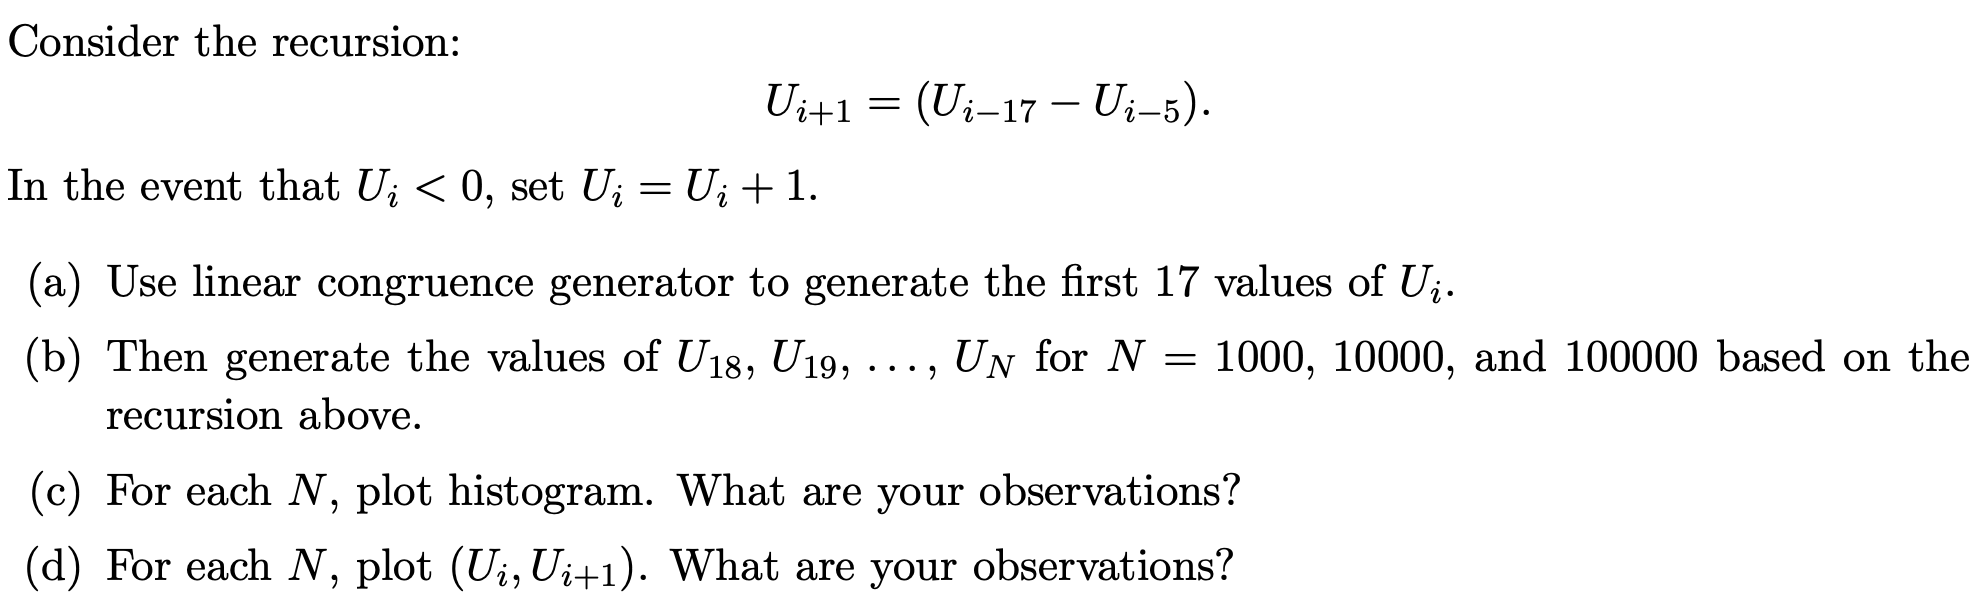

In [3]:
# Generate first 17 values of U_i.
result1, u_result1, col_names1 = LCG(a=6, b=0, m=11, samples=17, mode=2, x0_values=1)
result1_df = displayGeneration(result1, col_names1)
result1_df.T

x_0/i,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
10,10,5,8,4,2,1,6,3,7,9,10,5,8,4,2,1,6,3


### N = 1,000

In [4]:
u_result1 = fibbGenerator(u_result1, N=1_000, nu=17, mu=5)
u_result1 = u_result1.reshape(-1, 1)
groupings1, group_index1 = splitGroups(u_result1)
grouping1_df = displayGeneration(groupings1, col_names1, mode="g", index=group_index1)
grouping1_df

,10
range/x_0,
"[0.0, 0.05)",45
"[0.05, 0.1)",88
"[0.1, 0.15)",23
"[0.15, 0.2)",60
"[0.2, 0.25)",20
"[0.25, 0.3)",79
"[0.3, 0.35)",29
"[0.35, 0.4)",65
"[0.4, 0.45)",22


<Figure size 1600x600 with 0 Axes>

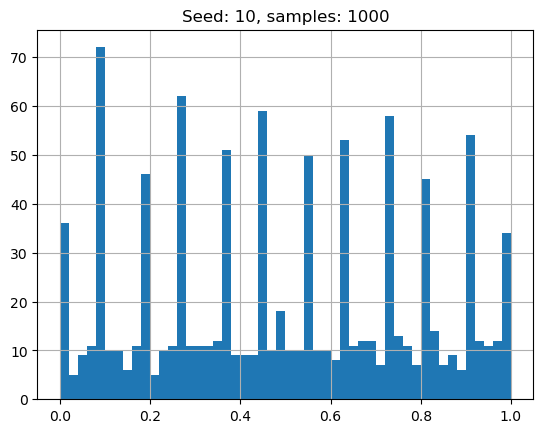

In [5]:
u_result1_df = pd.DataFrame(u_result1, columns=col_names1)
plt.figure(figsize=(16, 6))
u_result1_df.hist(bins=50, grid=True)
plt.title(f"Seed: {10}, samples: {1_000}")
plt.savefig("task1-1:1,000")
plt.show()

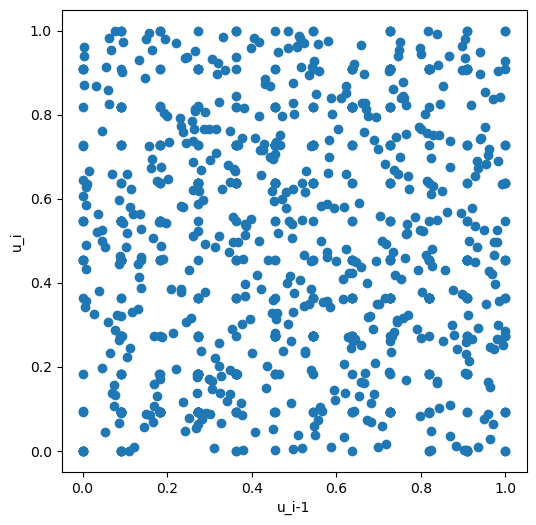

In [6]:
plotObservations(groupings1=u_result1, col_names=col_names1, mode=2, file_name="task1-2:1,000")

### N = 10,000

<Figure size 1600x600 with 0 Axes>

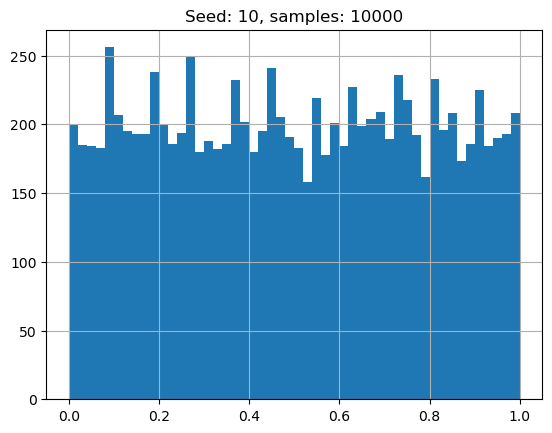

In [7]:
result2, u_result2, col_names2 = LCG(a=6, b=0, m=11, samples=17, mode=2, x0_values=1)
result2_df = displayGeneration(result2, col_names2)
#result1_df.to_csv("task1-1_result.csv", index=True)
#result1_df
u_result2 = fibbGenerator(u_result2, N=10_000, nu=17, mu=5)
u_result2 = u_result2.reshape(-1, 1)
groupings2, group_index2 = splitGroups(u_result2)
grouping2_df = displayGeneration(groupings2, col_names2, mode="g", index=group_index2)
#grouping1_df
u_result2_df = pd.DataFrame(u_result2, columns=col_names2)
plt.figure(figsize=(16, 6))
u_result2_df.hist(bins=50, grid=True)
plt.title(f"Seed: {10}, samples: {10_000}")
plt.savefig("task1-1:10,000")
plt.show()

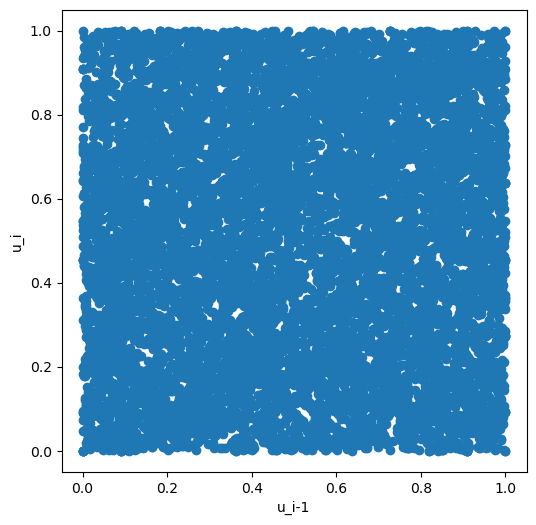

In [8]:
plotObservations(groupings1=u_result2, col_names=col_names2, mode=2, a1=6, file_name="task1-2:10,000")

### N = 100,000

<Figure size 1600x600 with 0 Axes>

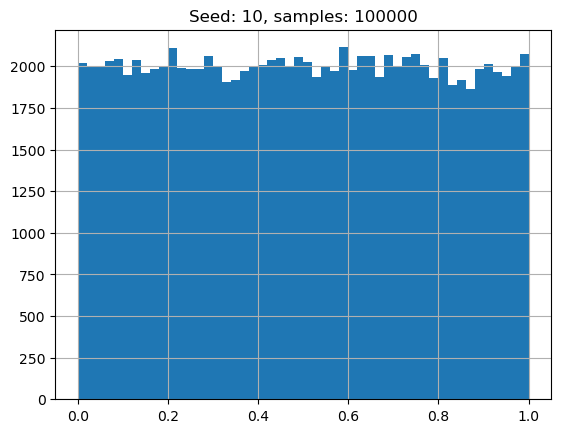

In [9]:
result3, u_result3, col_names3 = LCG(a=6, b=0, m=11, samples=17, mode=2, x0_values=1)
result3_df = displayGeneration(result2, col_names2)
#result1_df.to_csv("task1-1_result.csv", index=True)
#result1_df
u_result3 = fibbGenerator(u_result3, N=100_000, nu=17, mu=5)
u_result3 = u_result3.reshape(-1, 1)
groupings3, group_index3 = splitGroups(u_result3)
grouping3_df = displayGeneration(groupings3, col_names3, mode="g", index=group_index3)
#grouping1_df
u_result3_df = pd.DataFrame(u_result3, columns=col_names3)
plt.figure(figsize=(16, 6))
u_result3_df.hist(bins=50, grid=True)
plt.title(f"Seed: {10}, samples: {100_000}")
plt.savefig("task1-1:100,000")
plt.show()

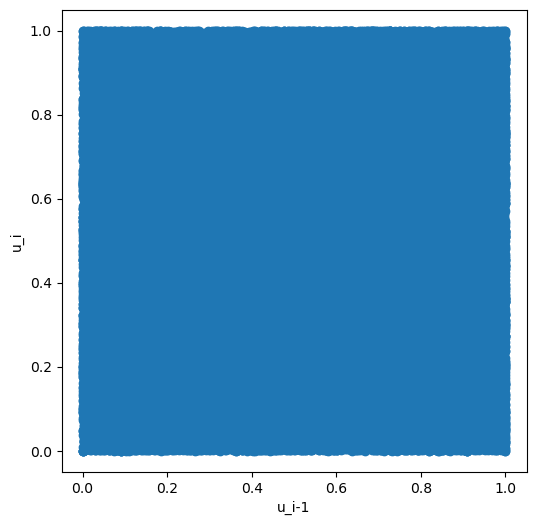

In [10]:
plotObservations(groupings1=u_result3, col_names=col_names3, mode=2, a1=6, file_name="task1-2:100,000")

## Question 2

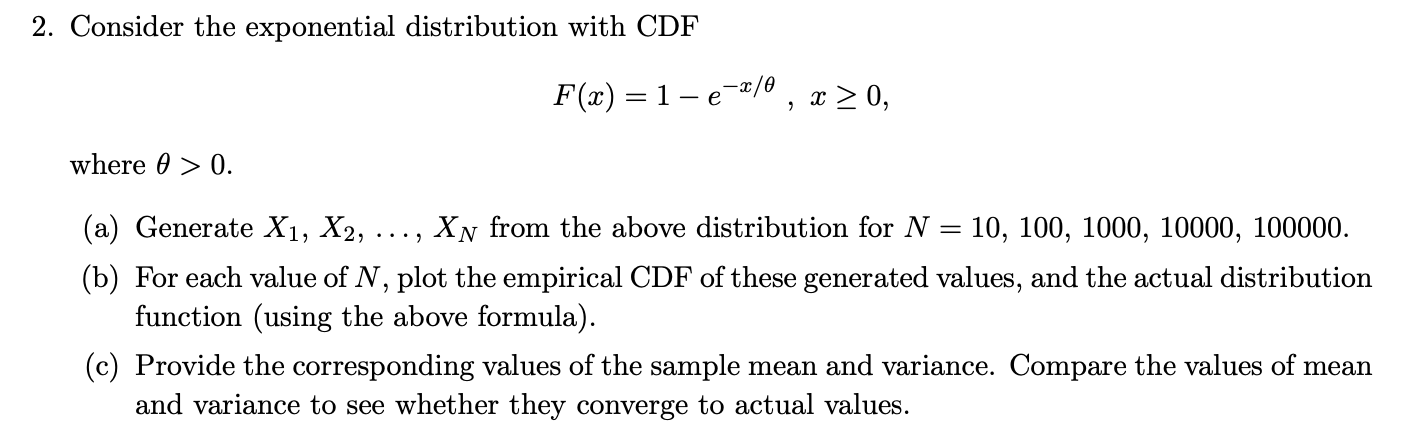

Plan:
1) Generate uniform distribution random numbers from numpy library and plug them into inverse function of exponential distribution. Result: X<br>
2) Sort X and plug X into PDF of X and plot it.<br>
3) Repeat the same for CDF.<br>
4) Calculate mean and variance of the distribution and compare it with the expected mean and varianes.<br>

In [11]:
def expCDFinv(F_x, theta):
    X = -theta * (np.log(1 - F_x))
    return X


def arcsinCDFinv(F_x):
    X = np.square(np.sin(F_x * (np.pi / 2)))
    return X


def getPDF(X, fileName, Q):
    plt.figure(figsize=(16, 6))
    if Q == 1:
        heights, labels = np.histogram(X, bins=np.arange(np.min(X), np.max(X) + 1, 0.1))
    else:
        heights, labels = np.histogram(X, bins=np.arange(0, 1 + 0.01, 0.01))
#     plt.plot(labels[:-1], heights)
#     plt.title(f"Freq. Dist. N: {len(X)}")
#     plt.savefig(fileName)
#     plt.show()
    return heights, labels
    
    
def plotCDF(X, fileName, heights, labels):
    plt.figure(figsize=(16, 6))
    cumm_heights = np.cumsum(heights) / np.sum(heights)
    plt.plot(labels[:-1], cumm_heights)
    plt.title(f"Empirical CDF, N: {len(X)}")
    plt.savefig(fileName)
    plt.show()
    return cumm_heights


def plotActualCDF(sample_size, m, M, theta, Q, fileName):
    plt.figure(figsize=(16, 6))
    x_vals = np.linspace(m, M, sample_size)
    
    if Q == 1:
        y = 1 - np.exp(-x_vals / theta)
    else:        
        y = (2 / np.pi) * np.arcsin(np.sqrt(x_vals))
        
    plt.plot(x_vals, y)
    plt.title(f"Actual CDF, N: {len(X)}")
    plt.savefig(fileName)
    plt.show()

<Figure size 1600x600 with 0 Axes>

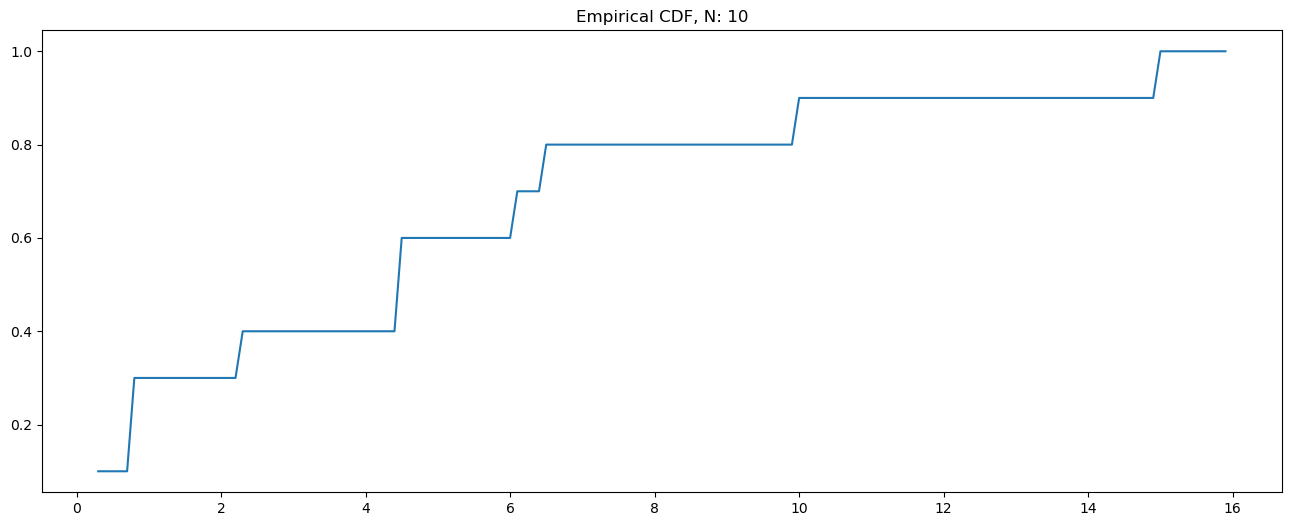

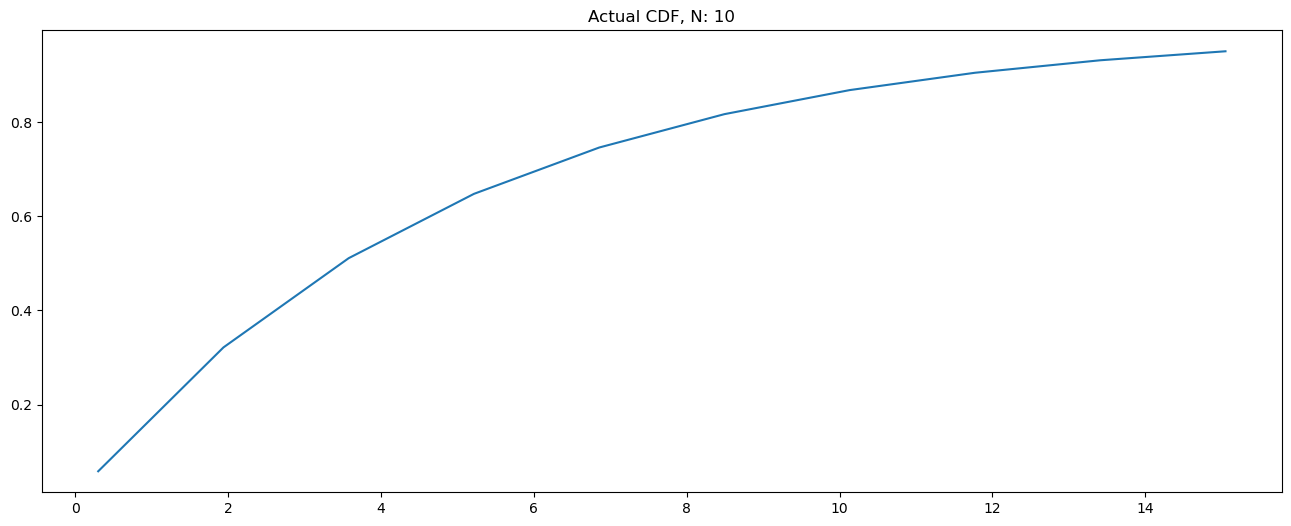

<Figure size 1600x600 with 0 Axes>

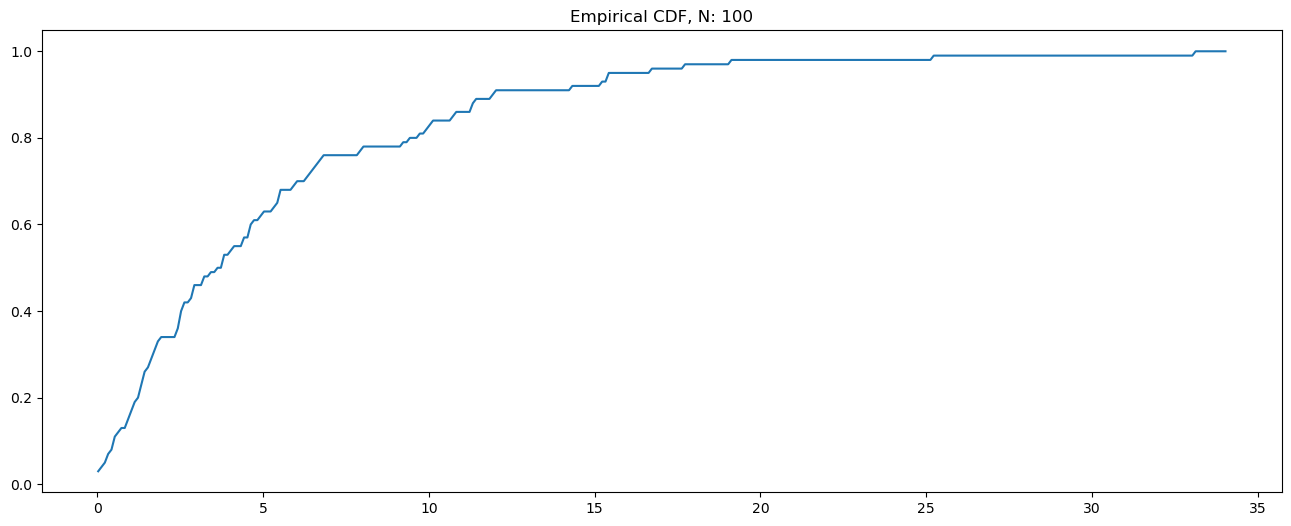

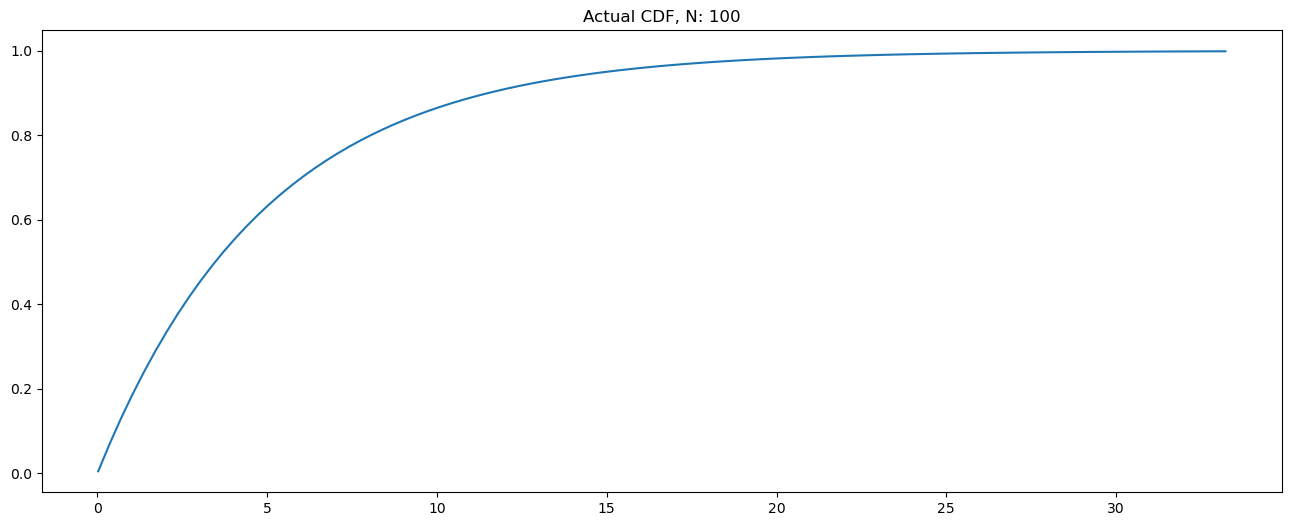

<Figure size 1600x600 with 0 Axes>

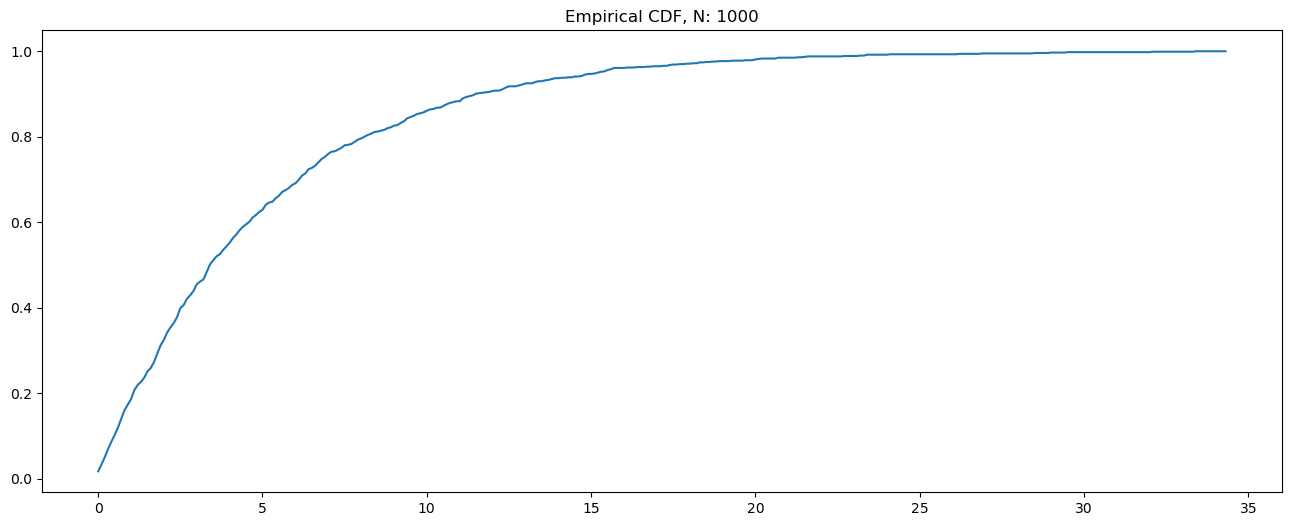

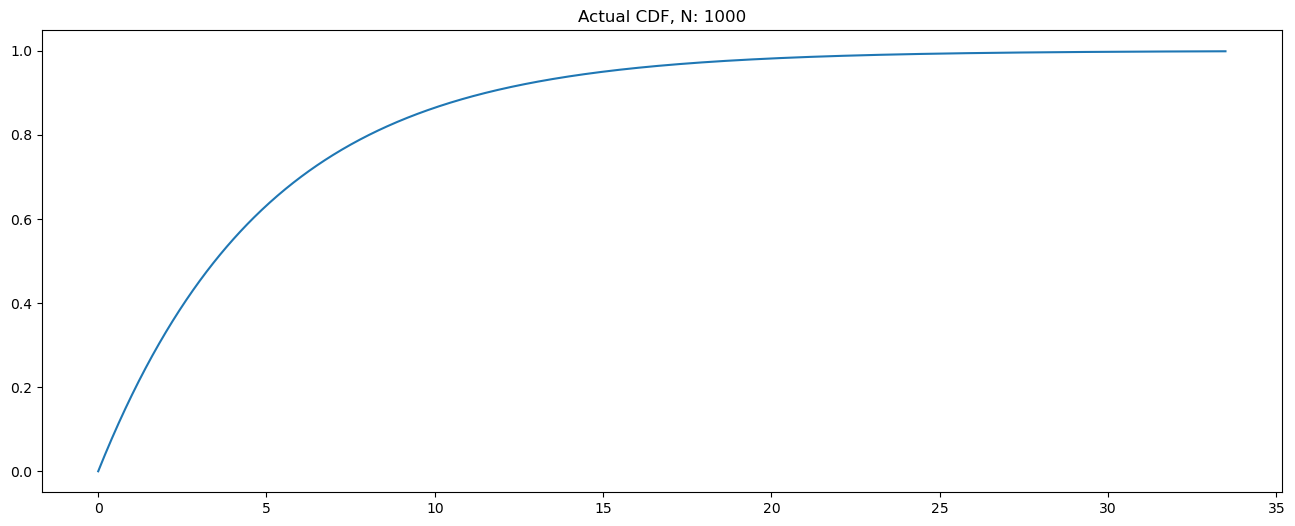

<Figure size 1600x600 with 0 Axes>

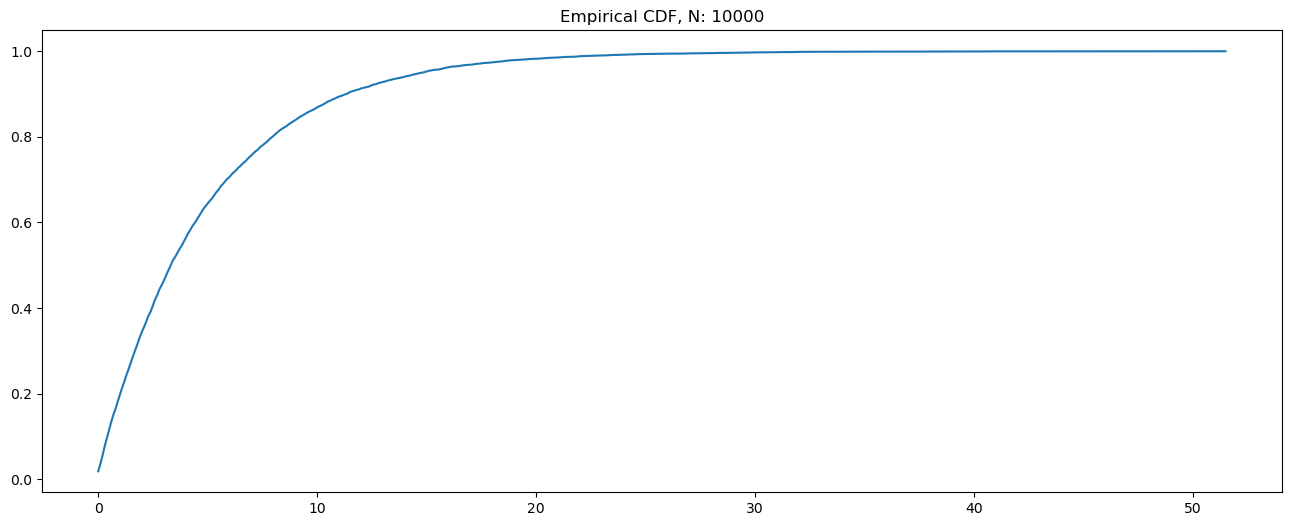

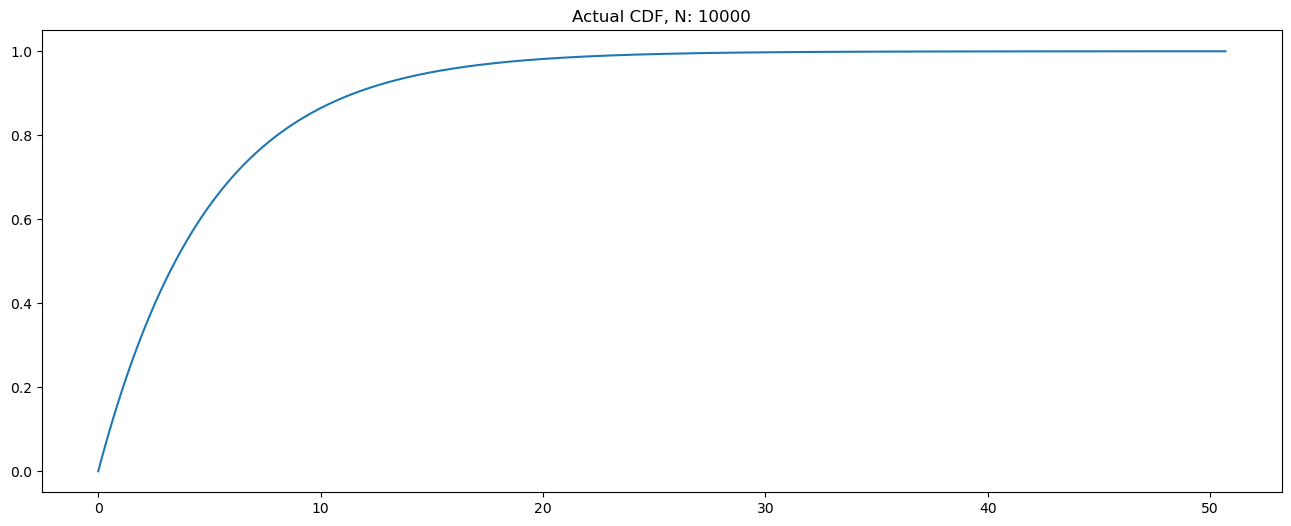

<Figure size 1600x600 with 0 Axes>

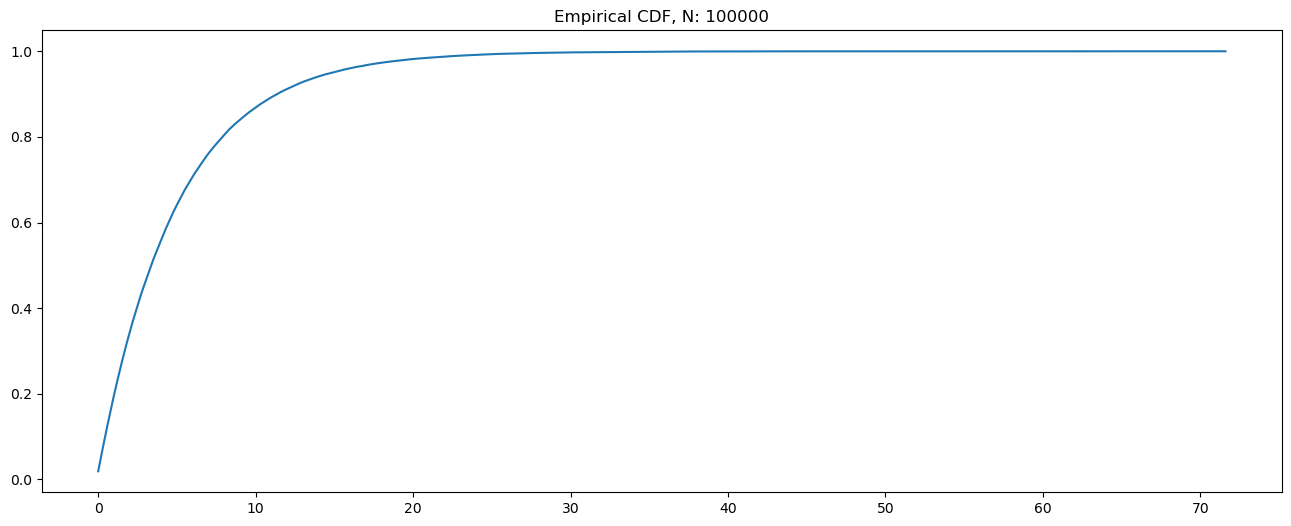

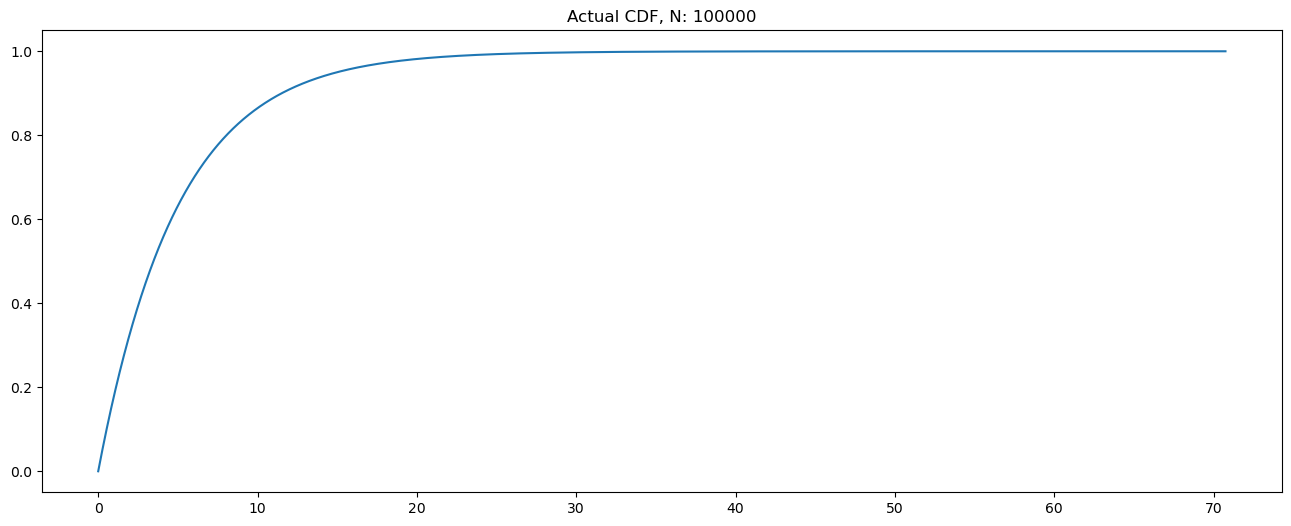

In [12]:
# Sample sizes.
N_ = np.array([10, 100, 1_000, 10_000, 100_000])

means, variances = list(), list()
theta = 5

for idx, N in enumerate(N_):
    # Generate random numbers from uniform distribution.
    np.random.seed(42 + idx)
    uni_CDF = np.random.uniform(size=N)
    
    # Get random variable distribution for corresponding CDF values.
    X = expCDFinv(uni_CDF, theta)
    X = np.sort(X)
    
    # Plot CDF and freq dist.
    heights, labels = getPDF(X, f"Task2Freq_N:{N}", Q=1)
    cumm_heights = plotCDF(X, f"Task2CDF_N:{N}", heights, labels)
    plotActualCDF(N, np.min(X), np.max(X), 5, 1, f"Task2ActualCDF_N:{N}")
    
    # Collect observed mean and variance to check for convergence.
    means.append(np.mean(X))
    variances.append(np.var(X))
    
# Organizing collected mean and variance.
means = np.array(means).reshape(len(N_), 1)
var = np.array(variances).reshape(len(N_), 1)
N_ = N_.reshape(len(N_), 1)

observed_stats_exp = pd.DataFrame(np.concatenate((N_, means, var), axis=1), columns=["N", "Mean", "Variance"])
observed_stats_exp.set_index("N", inplace=True)

In [13]:
observed_stats_exp

,Mean,Variance
N,,
10.0,5.134850,19.421265
100.0,5.463334,31.870798
1000.0,5.119377,25.123556
10000.0,4.970293,24.806548
100000.0,4.985525,24.989454


In [14]:
print(f"Actual mean: {theta}")
print(f"Actual variance: {theta ** 2}")

Actual mean: 5
Actual variance: 25


## Question 3

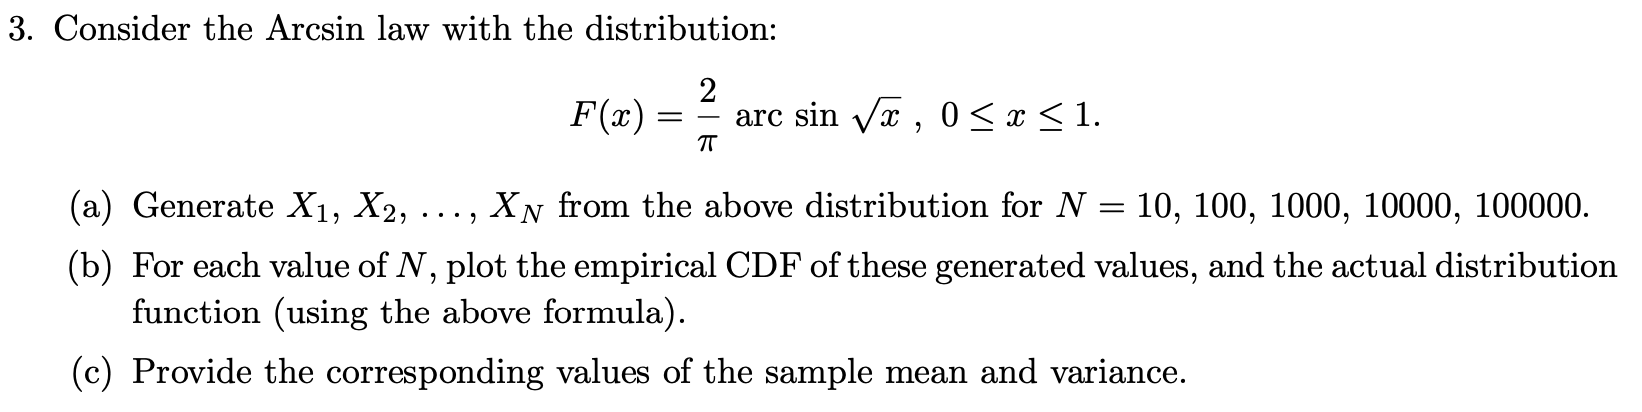

<Figure size 1600x600 with 0 Axes>

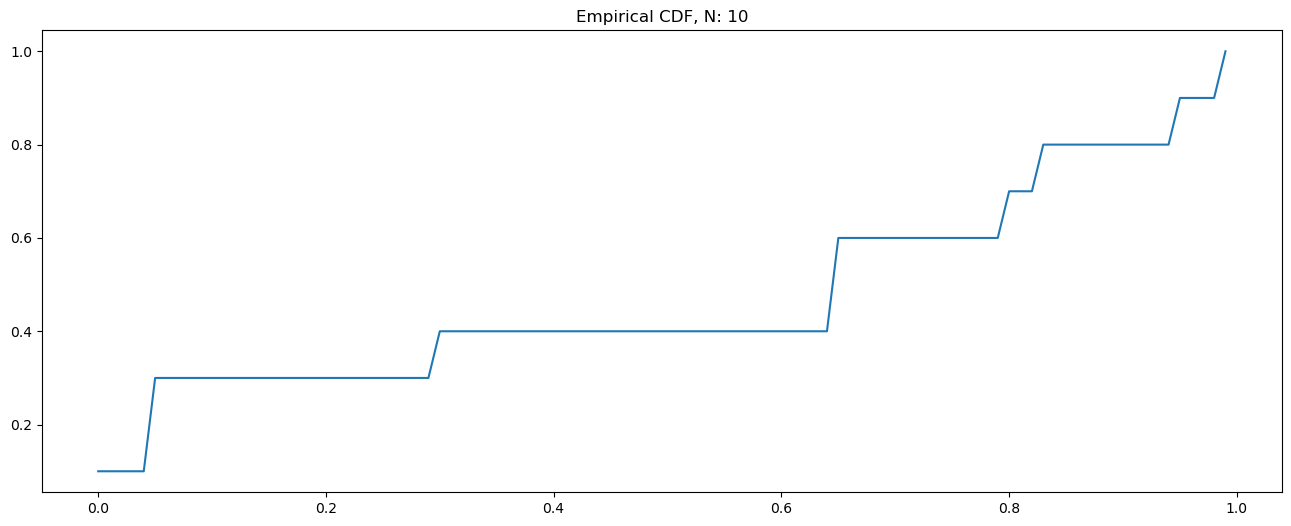

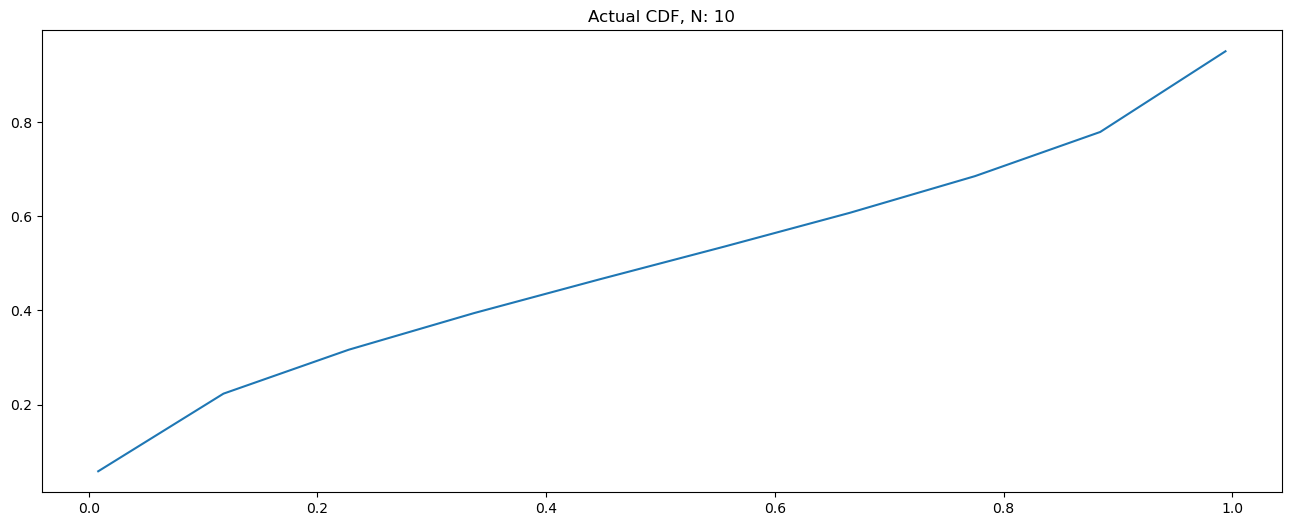

<Figure size 1600x600 with 0 Axes>

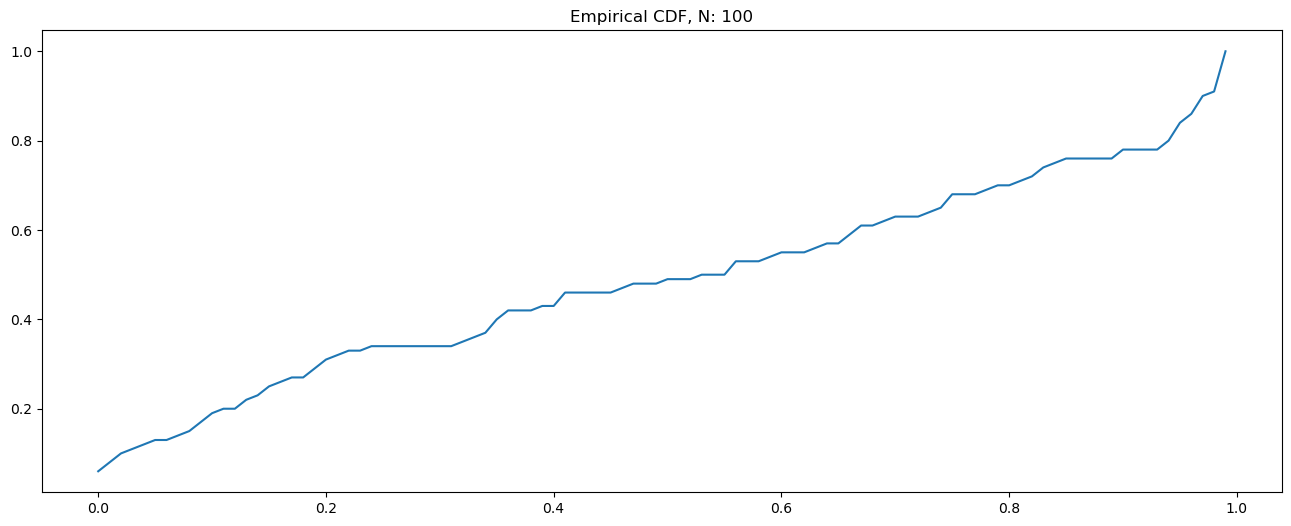

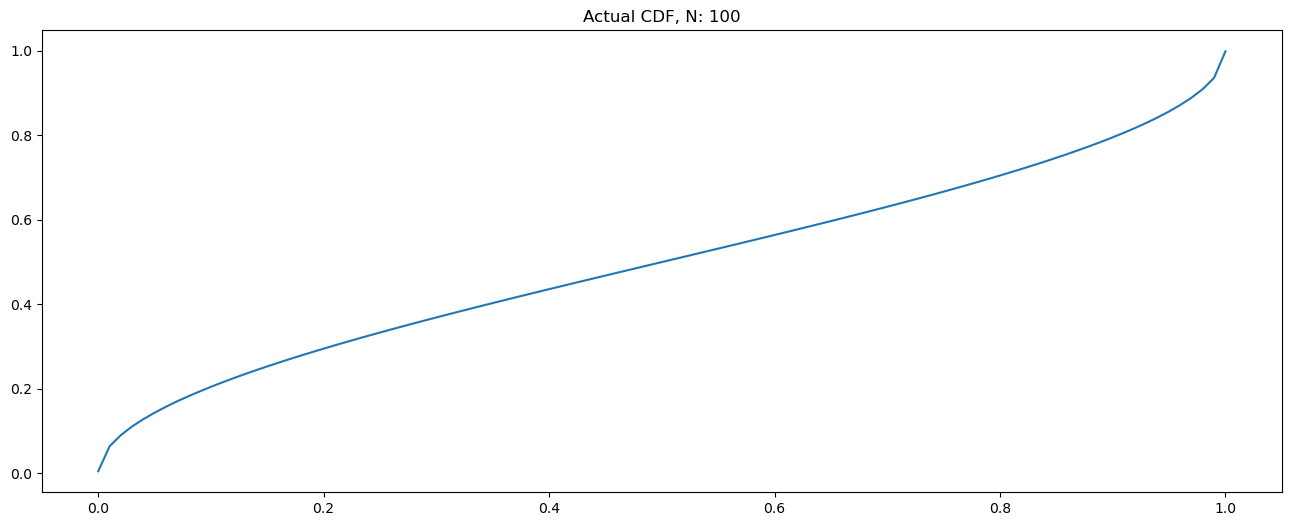

<Figure size 1600x600 with 0 Axes>

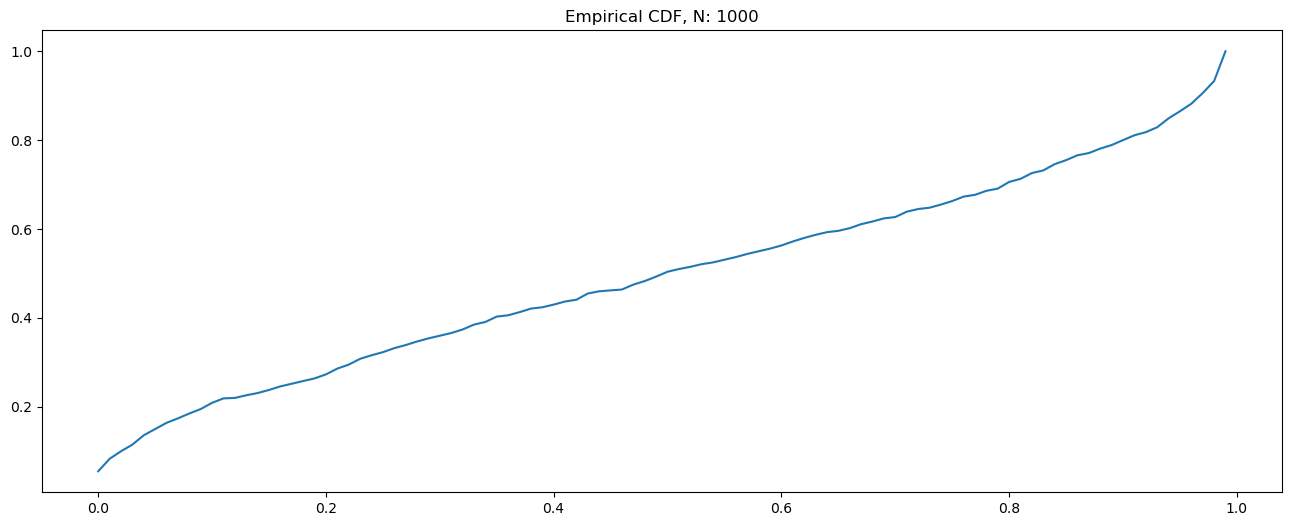

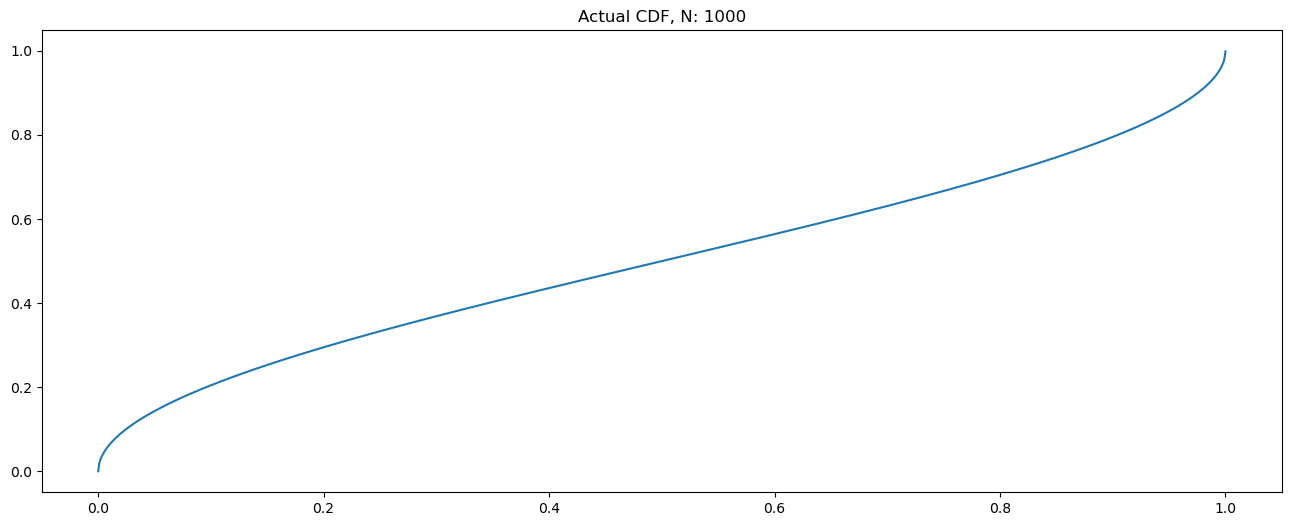

<Figure size 1600x600 with 0 Axes>

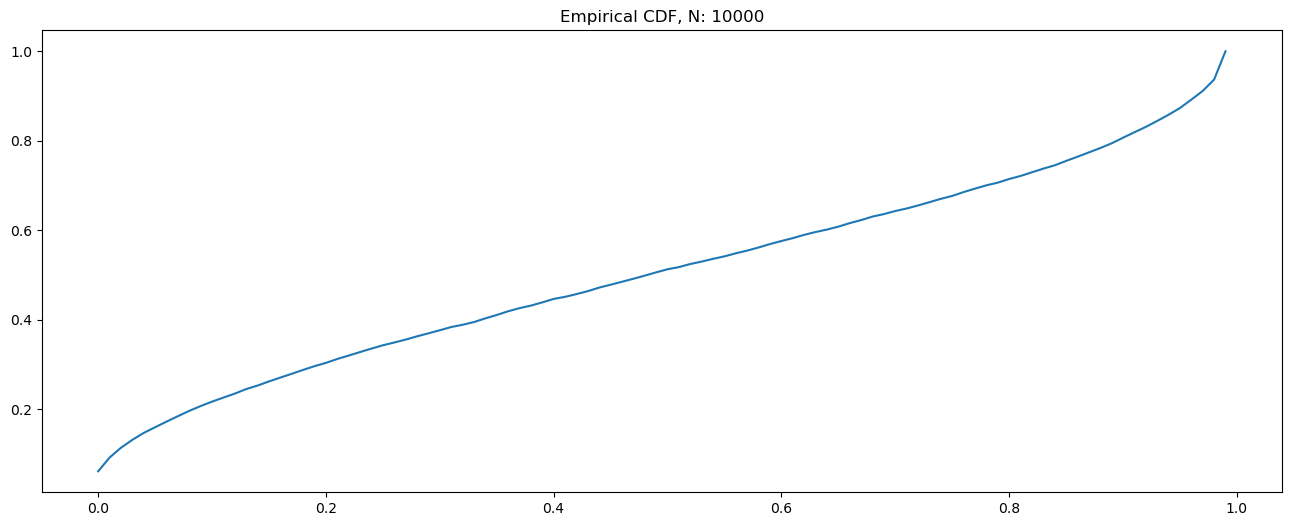

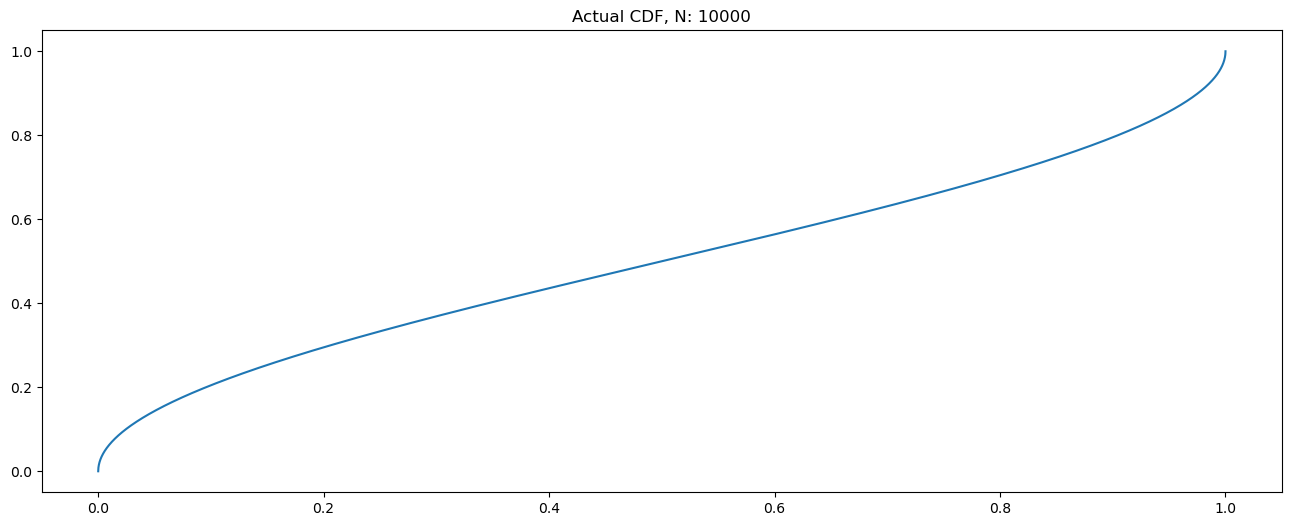

<Figure size 1600x600 with 0 Axes>

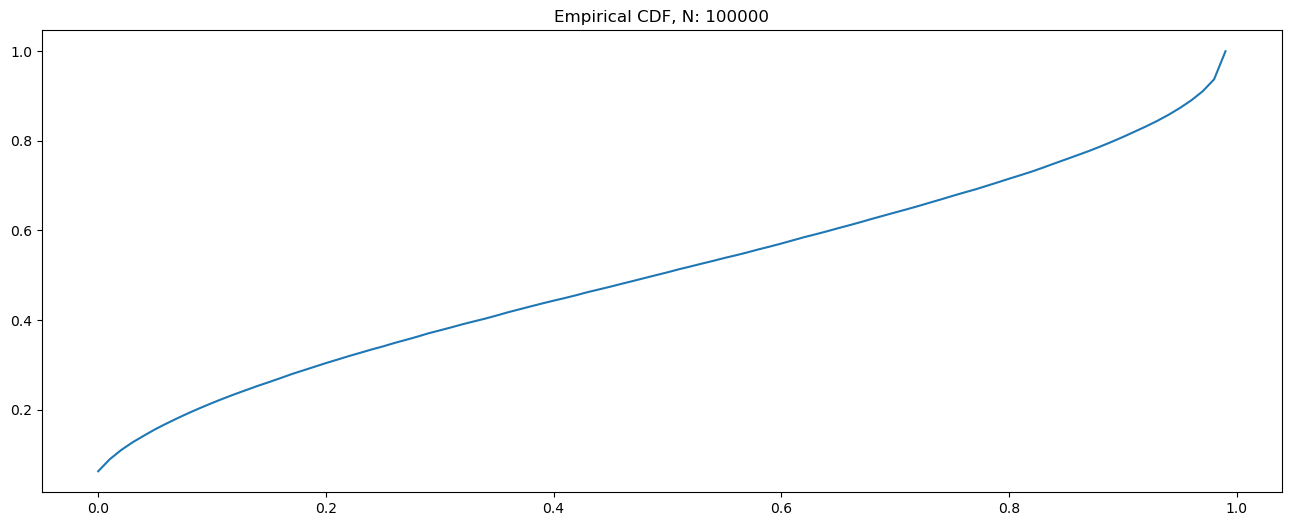

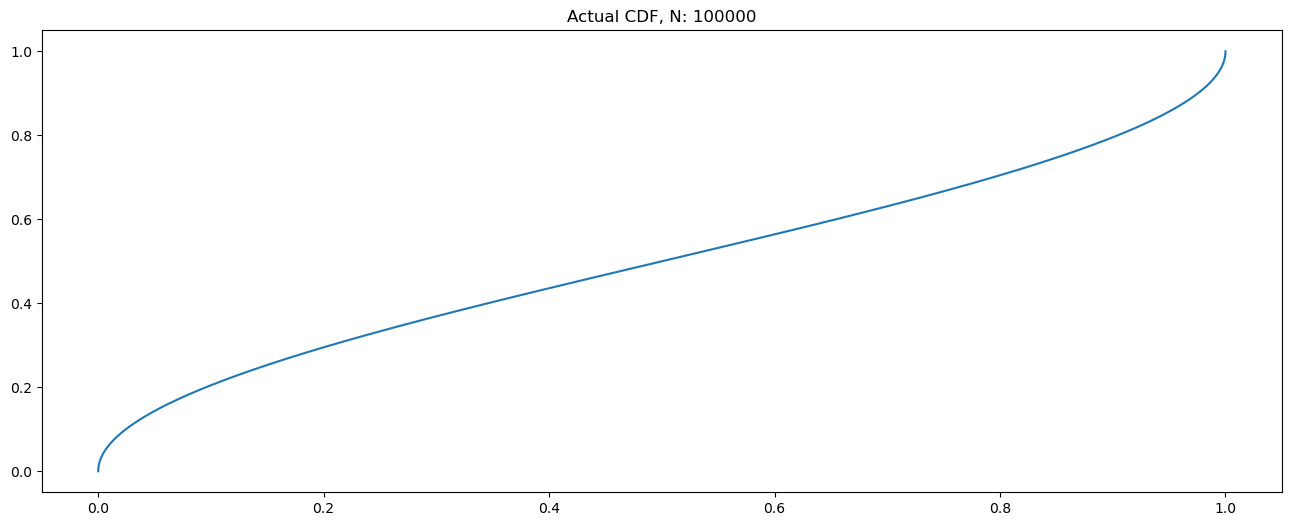

In [15]:
# Sample sizes.
N_ = np.array([10, 100, 1_000, 10_000, 100_000])

means, variances = list(), list()
theta = 5

for idx, N in enumerate(N_):
    # Generate random numbers from uniform distribution.
    np.random.seed(42 + idx)
    uni_CDF = np.random.uniform(size=N)
    
    # Get random variable distribution for corresponding CDF values.
    X = arcsinCDFinv(uni_CDF)
    X = np.sort(X)
    
    # Plot CDF and freq dist.
    heights, labels = getPDF(X, f"Task3Freq_N:{N}", Q=2)
    cumm_heights = plotCDF(X, f"Task3CDF_N:{N}", heights, labels)
    plotActualCDF(N, np.min(X), np.max(X), 5, 2, f"Task3ActualCDF_N:{N}")
    
    # Collect observed mean and variance to check for convergence.
    means.append(np.mean(X))
    variances.append(np.var(X))
    
# Organizing collected mean and variance.
means = np.array(means).reshape(len(N_), 1)
var = np.array(variances).reshape(len(N_), 1)
N_ = N_.reshape(len(N_), 1)

observed_stats_arcsin = pd.DataFrame(np.concatenate((N_, means, var), axis=1), columns=["N", "Mean", "Variance"])
observed_stats_arcsin.set_index("N", inplace=True)

In [16]:
observed_stats_arcsin

,Mean,Variance
N,,
10.0,0.533022,0.136034
100.0,0.517740,0.125749
1000.0,0.510495,0.122916
10000.0,0.497866,0.124823
100000.0,0.499259,0.124405


## Question 4

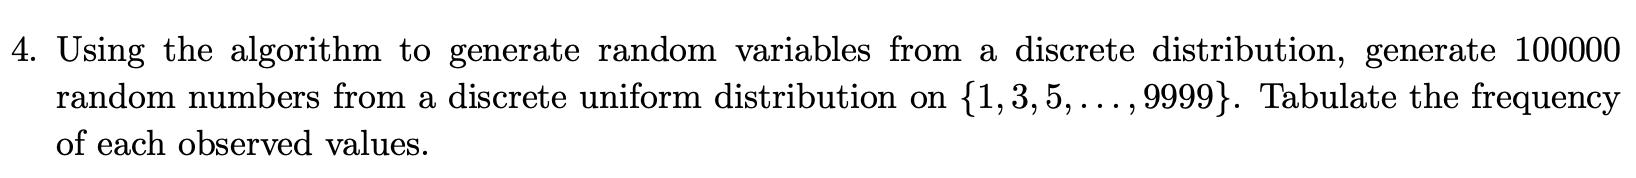

Plan:
1) Generate uniform random distribution on U(0, 1) for 100,000 samples.<br>
2) For each randomly generated sample u find i for which q_i-1 < u <= q_i.<br>
3) Return c_i.

In [17]:
K = np.arange(1, 10_000, 2)
q = [i / 5000 for i in range(1, len(K) + 1)]

samples = np.zeros(len(K))

In [18]:
sample_size = 100_000
np.random.seed(42)
uni_dist = np.random.uniform(size=sample_size)

for u in uni_dist:
    for i in range(1, 5000):
        if q[i - 1] < u <= q[i]:
            samples[i] += 1
            break

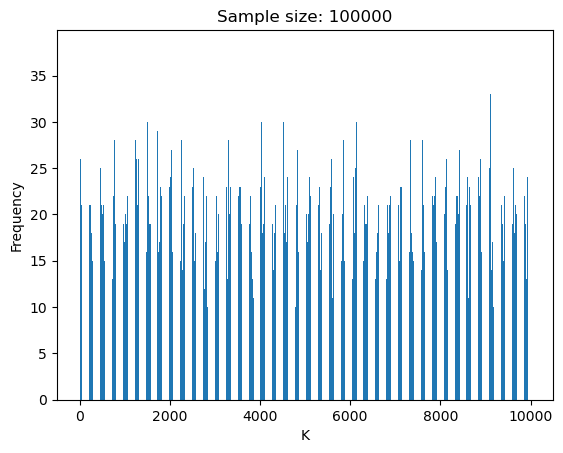

In [19]:
plt.bar(x=K, height=samples)
plt.title(f"Sample size: {sample_size}")
plt.xlabel("K")
plt.ylabel("Frequency")
plt.savefig("task4")
plt.show()